<a href="https://colab.research.google.com/github/caroldaza/DM_CyT/blob/main/smallworldofwords_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/')

In [ ]:
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_context('poster')
mpl.rcParams['figure.figsize'] = (8,6)

import numpy as np
import pandas as pd   

!pip install networkx powerlaw community

import networkx as nx
import community
import powerlaw
from gensim import corpora, models, similarities, matutils
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors

from sklearn.metrics import adjusted_rand_score

In [ ]:
filename = '/content/drive/MyDrive/SWOW-EN.R100.csv.zip'
datos = pd.read_csv(filename, sep=',')
datos.head()

,Unnamed: 0,id,participantID,age,gender,nativeLanguage,country,education,created_at,cue,R1,R2,R3
0,1,29,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,although,nevertheless,yet,but
1,2,30,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,deal,no,cards,shake
2,3,31,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,music,notes,band,rhythm
3,4,32,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,inform,tell,rat on,NaN
4,5,33,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,way,path,via,method


In [ ]:
# Nos quedamos solo con la cue y la primera palabra. Tambien botamos Nans
data = datos.loc[:,['cue','R1']]
data = data.dropna(how='any')

# Sacar palabras de una letra
data.drop(data[data['cue'].str.len().lt(2)].index, inplace=True)
data.drop(data[data['R1'].str.len().lt(2)].index, inplace=True)

data.head()

,cue,R1
0,although,nevertheless
1,deal,no
2,music,notes
3,inform,tell
4,way,path


In [ ]:
data.shape[0]

1194119

In [ ]:
# ¿Cuántas claves y respuestas son únicas?
print(data['cue'].unique().shape)
print(data['R1'].unique().shape)

(12258,)
(64663,)


In [ ]:
# ¿cuántas palabras de R1 están en Cue? ¿alrevés?
print(sum(data['R1'].isin(data['cue'].unique())))
print(sum(data['cue'].isin(data['R1'].unique())))

1067977
1185365


In [ ]:
# Sacar palabras que no este en cue Y en R1
data.drop(data[data['R1'].isin(data['cue'].unique())==False].index, inplace=True)
data.drop(data[data['cue'].isin(data['R1'].unique())==False].index, inplace=True)

In [ ]:
data.shape[0]

1060109

In [ ]:
new_df = data['cue'].str.split(expand=True).stack().value_counts().reset_index()
new_df.columns = ['Word', 'Frequency'] 

In [ ]:
new_df

,Word,Frequency
0,up,2021
1,not,1167
2,out,1061
3,on,961
4,down,830
...,...,...
11868,ping,33
11869,Homer,29
11870,adrenal,26
11871,Sherlock,23


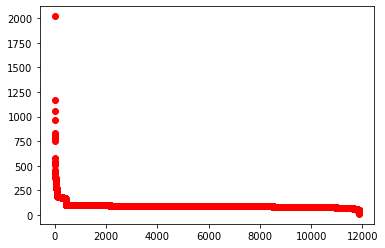

In [ ]:

plt.plot(new_df['Frequency'],'ro')

Text(0, 0.5, 'frequency')

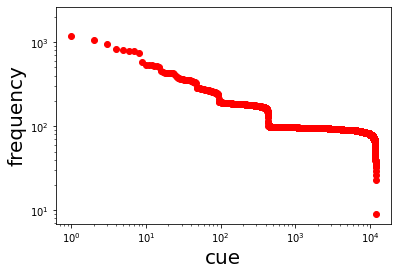

In [ ]:

#plt.loglog(np.linspace(1, len(new_df['Frequency']),len(new_df['Frequency'])),new_df['Frequency'].to_numpy())
pyplot.yscale('log')
pyplot.xscale('log')
plt.plot(new_df['Frequency'],'ro')
plt.xlabel("cue",fontsize=20)
plt.ylabel("frequency",fontsize=20)

In [ ]:
new_df_R1 = df['R1'].str.split(expand=True).stack().value_counts().reset_index()
new_df_R1.columns = ['Word', 'Frequency'] 

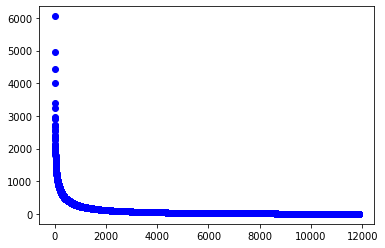

In [ ]:
plt.plot(new_df_R1['Frequency'],'bo')

Text(0, 0.5, 'frequency')

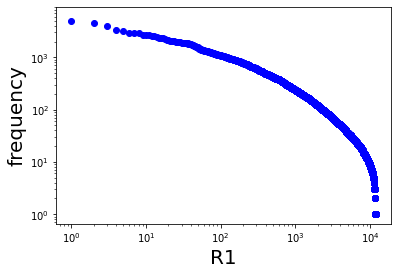

In [ ]:
pyplot.yscale('log')
pyplot.xscale('log')
plt.plot(new_df_R1['Frequency'],'bo')
plt.xlabel("R1",fontsize=20)
plt.ylabel("frequency",fontsize=20)

In [ ]:
# Creando una lista de tuplas para calcular la frecuencia de pares
lista = np.array(data)
lista_tuplas = tuple(map(tuple, lista))
lista_tuplas[0:5]

(('although', 'nevertheless'),
 ('deal', 'no'),
 ('music', 'notes'),
 ('inform', 'tell'),
 ('way', 'path'))

In [ ]:
len(lista_tuplas)

1060109

In [ ]:
import collections 
Output = collections.defaultdict(int)

for elem in lista_tuplas:
      Output[elem[0]] += 1
      
# Printing output
print(Output)

defaultdict(<class 'int'>, {'although': 89, 'deal': 89, 'music': 92, 'inform': 97, 'way': 88, 'extra': 97, 'will': 89, 'paper': 94, 'contract': 93, 'concern': 97, 'town': 88, 'couple': 90, 'mind': 98, 'maybe': 94, 'read': 92, 'board': 89, 'check': 92, 'occasion': 97, 'real': 94, 'seat': 95, 'chair': 94, 'provide': 90, 'budget': 94, 'land': 91, 'village': 90, 'feed': 95, 'exist': 98, 'Sunday': 93, 'wee': 94, 'glass': 95, 'sister': 83, 'know': 89, 'claim': 91, 'stairs': 93, 'dog': 92, 'key': 97, 'all': 90, 'grand': 94, 'carry': 96, 'recent': 85, 'simple': 92, 'set': 92, 'across': 83, 'parent': 98, 'Mrs': 80, 'plus': 94, 'wrong': 97, 'go': 96, 'assume': 83, 'pay': 98, 'possible': 88, 'pardon': 91, 'sheet': 97, 'industrialize': 77, 'act': 93, 'choice': 95, 'understand': 90, 'example': 78, 'space': 92, 'sleep': 94, 'cook': 95, 'waste': 96, 'well': 92, 'month': 93, 'tie': 92, 'advertise': 90, 'guess': 92, 'science': 92, 'reckon': 89, 'radio': 80, 'nation': 88, 'good': 96, 'part': 95, 'feel':

In [ ]:
import collections 
Output = collections.defaultdict(int)

for elem in lista_tuplas:
      Output[elem] += 1
print('numero parejas',len(Output))

numero parejas 385816


In [ ]:
Output

defaultdict(int,
            {('although', 'nevertheless'): 1,
             ('deal', 'no'): 3,
             ('music', 'notes'): 10,
             ('inform', 'tell'): 54,
             ('way', 'path'): 19,
             ('extra', 'plus'): 6,
             ('will', 'free'): 2,
             ('paper', 'book'): 3,
             ('contract', 'legality'): 1,
             ('concern', 'worry'): 41,
             ('town', 'village'): 11,
             ('couple', 'few'): 2,
             ('mind', 'brain'): 22,
             ('maybe', 'sometimes'): 6,
             ('read', 'write'): 18,
             ('board', 'plank'): 6,
             ('check', 'tick'): 4,
             ('occasion', 'event'): 23,
             ('real', 'true'): 22,
             ('seat', 'chair'): 40,
             ('chair', 'seat'): 18,
             ('provide', 'rely'): 1,
             ('budget', 'money'): 48,
             ('land', 'home'): 1,
             ('village', 'land'): 1,
             ('feed', 'eat'): 21,
             ('exist', 'is'):

In [ ]:
#Verificando que las frecuencias sumadas de las parejas dé el total de elementos de la lista
sum =0 
for key, value in Output.items():
	sum = sum + value

sum

1060109

In [ ]:
# parejas con frecuencia igual a 1
unicas = [s for s in Output.values() if s == 1]
len(unicas)

254309

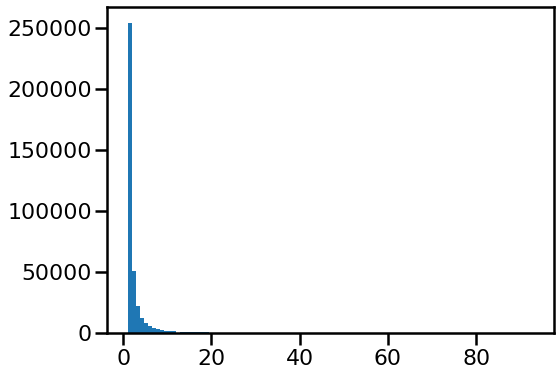

In [ ]:
n,bins,patch = plt.hist(list(Output.values()), bins=100)

In [ ]:
min(Output.values()), max(Output.values()),statistics.median(Output.values()),statistics.mean(Output.values())

(1, 93, 1.0, 2.7477061604495407)

Con filtrar las que aparecen una sola vez, ya filtro mas de la mitad de los datos (~66%)

In [252]:
output_short = dict(filter(lambda val: val[1]>1, Output.items())) #filtrando con frecuencia >1
len(output_short)

131507

In [ ]:
#b = [0 for a in range(3)]
#c = np.zeros(shape=(1,4))
#output_short_frecs = np.zeros(shape=(len(output_short),4))

#for k in range(len(output_short)):
#  b = np.hstack((np.array(out_short_arr[k][0]),out_short_arr[k][1])) #vuelvo out_short[k] un array (era un diccionario)
#  for i in range(len(new_df)):
#    if b[0] == new_df.iloc[i][0]:   # busco donde coincide la cue del array con la de la tabla de frecuencias
#      c = np.hstack((b,np.array(new_df.iloc[i][1]))) # agrego la frecuencia de la cue
#  np.append(output_short_frecs,c)



In [ ]:
#data_short = np.zeros(shape=(len(out_short_arr),2))

#for i in range(len(out_short_arr)):
#  np.append(data_short,np.array(out_short_arr[i][0]))


In [286]:
# Convertiendo de nuevo a array
short_data1 = []
short_data2 = []

for i in range(len(out_short_arr)):
  short_data1.append(out_short_arr[i][0][0])
  short_data2.append(out_short_arr[i][0][1])

aux1 = pd.DataFrame(short_data1, columns = ['cue'])
aux2 = pd.DataFrame(short_data2, columns = ['R1'])

data_cl_sh = pd.concat([aux1, aux2], join = 'outer', axis = 1)
data_cl_sh.head(10)

,cue,R1
0,deal,no
1,music,notes
2,inform,tell
3,way,path
4,extra,plus
5,will,free
6,paper,book
7,concern,worry
8,town,village
9,couple,few


In [287]:
data_cl_sh.shape[0], data_cl_sh.shape[1]

(131507, 2)

In [ ]:
w2v_model2 = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
# Armo una matriz de distancias
distancias_pre=np.zeros((len(lista_palabras),len(lista_palabras))) #matriz cuadrada
for i,ti in enumerate(lista_palabras):
  for j,tj in enumerate(lista_palabras):
    distancias_pre[i,j] = abs(1-w2v_model2.similarity(ti,tj))
print (distancias_pre.shape)
plt.imshow(distancias_pre)

In [ ]:
results = powerlaw.Fit(new_df['Frequency'])
results.power_law.alpha
results.power_law.sigma
results.distribution_compare('power_law', 'exponential')

Calculating best minimal value for power law fit


(4.929133857326881, 0.10396201876262783)

Text(0.5, 0, 'Cue Frequency')

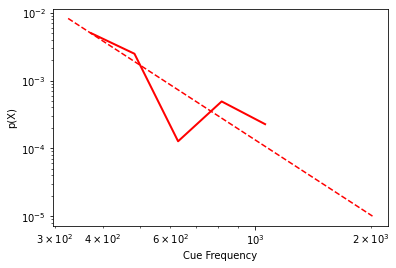

In [ ]:
figPDF = results.plot_pdf(color='r', linewidth=2)
results.power_law.plot_pdf(color='r', linestyle='--', ax=figPDF)

####
figPDF.set_ylabel(u"p(X)")
figPDF.set_xlabel(r"Cue Frequency")

In [ ]:
results_R1 = powerlaw.Fit(new_df_R1['Frequency'])
results_R1.power_law.alpha
results_R1.power_law.sigma
results_R1.distribution_compare('power_law', 'exponential')

Calculating best minimal value for power law fit


(5.437302213168326, 0.33576215594667147)

Text(0.5, 0, 'R1 Frequency')

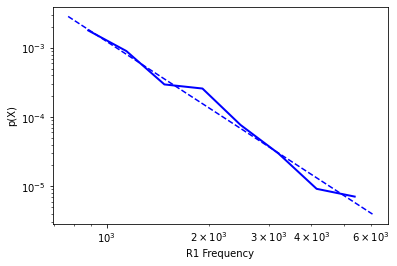

In [ ]:
figPDF = results_R1.plot_pdf(color='b', linewidth=2)
results_R1.power_law.plot_pdf(color='b', linestyle='--', ax=figPDF)

####
figPDF.set_ylabel(u"p(X)")
figPDF.set_xlabel(r"R1 Frequency")